In [1]:
%cd /kaggle/working

/kaggle/working


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import datetime
import sys
from tqdm import tqdm
import os
import random

# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.nn import functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

# CV
from PIL import Image

import pytorch_lightning as pl
from torchmetrics import MetricCollection, MeanSquaredError
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping


import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle')
from utils.metric import compute_comptetition_metric

2023-09-21 21:34:45.589817: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/opt/conda/lib
2023-09-21 21:34:45.590333: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/opt/conda/lib
2023-09-21 21:34:45.590342: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlo

In [3]:
config = f"""
execution:
    exp_id: exp_010
    debug: False
    submit: False

dataset: 
    competition_dir: /kaggle/input/child-mind-institute-detect-sleep-states
    cv_split_path: /kaggle/input/cv_split/train_folds.csv
    train_base_path: /kaggle/input/train_base/train_base.csv
    day_csv_dir: /kaggle/input/save_day_csv/day_csvs
    
seed: 46
n_fold: 5
"""

CFG = yaml.load(config, Loader=yaml.SafeLoader)

CFG["output_dir"] = f"/kaggle/output/{CFG['execution']['exp_id']}"
os.makedirs(CFG["output_dir"], exist_ok=True)

CFG["CACHE"] = {}

random.seed(CFG["seed"])
os.environ["PYTHONHASHSEED"] = str(CFG["seed"])
np.random.seed(CFG["seed"])

plt.rcParams["font.size"] = 13
warnings.filterwarnings('ignore')

In [4]:
CACHE = {}

In [5]:
# base df
train_base = pd.read_csv(CFG['dataset']['train_base_path'])
train_base["start_time"] = pd.to_datetime(train_base["start_time"], utc=True)
train_base["end_time"] = pd.to_datetime(train_base["end_time"], utc=True)

# cv split
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train_base = train_base.merge(cv_split, on="series_id", how="left")

# label
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna().reset_index(drop=True)

# デバッグ時はデータ数を減らす
if CFG['execution']['debug']:
    sample_series_id = random.sample(list(train_base["series_id"].unique()), 20)
    train_base = train_base[train_base["series_id"].isin(sample_series_id)].reset_index(drop=True)
    labels = labels[labels["series_id"].isin(sample_series_id)].reset_index(drop=True)

# 目的変数の欠損は平均値で埋める(TODO: ここは分類問題で弾く)
train_base["target"] = train_base["target"].fillna(train_base["target"].mean())

# 時間単位にする
train_base["target"] = train_base["target"] / (60 * 60 // 5) - 12

train_base.head()

,series_id,start_time,end_time,target_type,target_step,target_timestamp,sample_id,target,fold
0,038441c925bb,2018-08-13 23:00:00+00:00,2018-08-14 22:59:59+00:00,wakeup,NaN,NaN,0,0.915524,2
1,038441c925bb,2018-08-14 23:00:00+00:00,2018-08-15 22:59:59+00:00,wakeup,10932.0,2018-08-15 10:41:00+00:00,1,-0.316667,2
2,038441c925bb,2018-08-15 23:00:00+00:00,2018-08-16 22:59:59+00:00,wakeup,27492.0,2018-08-16 09:41:00+00:00,2,-1.316667,2
3,038441c925bb,2018-08-16 23:00:00+00:00,2018-08-17 22:59:59+00:00,wakeup,44400.0,2018-08-17 09:10:00+00:00,3,-1.833333,2
4,038441c925bb,2018-08-17 23:00:00+00:00,2018-08-18 22:59:59+00:00,wakeup,62856.0,2018-08-18 10:48:00+00:00,4,-0.200000,2


## Dataset

In [6]:
def generate_features(series_id, sample_id):
    id = f"{series_id}_{sample_id}"
    if id in CFG["CACHE"]:
        df = CFG["CACHE"][id]
        return df

    train = pd.read_csv(f"{CFG['dataset']['day_csv_dir']}/{series_id}/{sample_id}.csv")

    if len(train) == 0:
        n = int(60 * 60 * 24 // 5)
        train = pd.DataFrame({
            "step": range(n),
            "anglez": np.zeros(n),
            "enmo": np.zeros(n),
            "mask": np.zeros(n),
            "for_wakeup": np.zeros(n),
        })
        train = train[["step", "for_wakeup", "anglez", "enmo"]].groupby(train["step"] // 100).mean()
        CFG["CACHE"][id] = train
        return train

    # wakeup or onset
    train["for_wakeup"] = float(train["target_type"].values[0] == "wakeup")

    # 開始時刻のギャップ
    train["step_diff_start"] = (pd.to_datetime(train["timestamp"][0]) - pd.to_datetime(train["start_time"][0])).total_seconds() // 5
    train["step_diff_end"] = (pd.to_datetime(train["end_time"].values[-1]) - pd.to_datetime(train["timestamp"].values[-1])).total_seconds() // 5

    # stepを統一する
    train = train.reset_index(drop=True)
    train["step"] = (train["step_diff_start"] + train.index).astype(int)
    train["mask"] = 1

    # padding
    head = pd.DataFrame({"step": range(int(train["step_diff_start"].values[0]))})
    tail = pd.DataFrame({"step": range(train["step"].values[-1] + 1, train["step"].values[-1] + int(train["step_diff_end"].values[0]) + 1)})
    train = pd.concat([head, train, tail]).reset_index(drop=True)

    # fillna
    train = train.fillna(0)

    train = train[["step", "for_wakeup", "anglez", "enmo"]].groupby(train["step"] // 100).mean()

    CFG["CACHE"][id] = train
    return train

In [23]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, train_base: pd.DataFrame, train_or_test="train"):
        self.train_or_test = train_or_test
        self.train_base = train_base

        self.series_ids = train_base["series_id"].values
        self.sample_ids = train_base["sample_id"].values
        self.targets = np.array(train_base["target"]).astype(np.float32)

    def __len__(self):
        return len(self.series_ids)

    def __getitem__(self, index):
        series_id = self.series_ids[index]
        sample_id = self.sample_ids[index]
        target = self.targets[index]

        df = generate_features(series_id, sample_id)
        X = df[["step", "anglez", "enmo", "for_wakeup"]].values.astype(np.float32)

        return X, target

class LightningDataModule(pl.LightningDataModule):
    def __init__(self, train_dataset=None, valid_dataset=None, 
                 test_dataset=None, batch_size=32):
        super().__init__()
        self.train_dataset = train_dataset
        self.valid_dataset = valid_dataset
        self.test_dataset = test_dataset
        self.batch_size = batch_size

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
                    self.train_dataset, batch_size=self.batch_size, shuffle=True, 
                    pin_memory=True, worker_init_fn=self.worker_init_fn, num_workers=2)
        
    def val_dataloader(self):
        return torch.utils.data.DataLoader(
                    self.valid_dataset, batch_size=self.batch_size, shuffle=False, 
                    pin_memory=True, worker_init_fn=self.worker_init_fn, num_workers=2)
        
    def test_dataloader(self):
        return torch.utils.data.DataLoader(
                    self.test_dataset, batch_size=self.batch_size, shuffle=False, 
                    pin_memory=True, worker_init_fn=self.worker_init_fn, num_workers=2)
        
    def worker_init_fn(self, worker_id):                                                 
        # dataloaderでnum_workers>1の時の乱数設定
        # これを指定しないと各workerのrandom_stateが同じになり、データも同じになる。         
        np.random.seed(np.random.get_state()[1][0] + worker_id)

In [24]:
dataset = MyDataset(train_base, train_or_test="train")
dataset[0]

(array([[ 4.9500000e+01,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 1.4950000e+02,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 2.4950000e+02,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 3.4950000e+02,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 4.4950000e+02,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 5.4950000e+02,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 6.4950000e+02,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 7.4950000e+02,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 8.4950000e+02,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 9.4950000e+02,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 1.0495000e+03,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 1.1495000e+03,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 1.2495000e+03,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 1.3495000e+03,  0.0000000e+0

In [9]:
# cache
for i in tqdm(range(len(dataset))):
    _ = dataset[i]

100%|██████████| 15406/15406 [09:32<00:00, 26.90it/s]


## Model

In [10]:
class LightningModel(pl.LightningModule):
    def __init__(self, loss_fn=nn.CrossEntropyLoss(), lr=0.001, weight_decay=0):
        super().__init__()
        
        # 数値特徴量とくっつけて、lstmに入力する
        dim_feature = 4
        hidden_size = 32
        self.layer_norm_input = nn.LayerNorm(dim_feature)
        self.lstm = nn.LSTM(
            input_size=dim_feature,
            hidden_size=hidden_size,
            num_layers=2,
            dropout=0.0,
            batch_first=True,
            bidirectional=True)

        # 各stepの出力(特徴量の次元)を1次元にする
        self.head = nn.Sequential(
            nn.Linear(2 * hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.0),
            nn.Linear(hidden_size, 1))

        self.loss_fn = loss_fn
        self.lr = lr
        self.weight_decay = weight_decay

        self.train_metrics = MetricCollection([MeanSquaredError()], prefix="")
        self.valid_metrics = MetricCollection([MeanSquaredError()], prefix="val_")
        
        self.val_step_outputs = []
        self.val_step_labels = []

    def forward(self, x):
        # layer norm
        # x = self.layer_norm_input(x)

        x, _ = self.lstm(x) # -> [bs, n_step, dim_feature]

        x = x[:, -1, :] # -> [bs, dim_feature]
        x = self.head(x) # -> [bs, 1]
        x = x.squeeze(1) # -> [bs]

        return x

    def training_step(self, batch, batch_idx):
        X, y = batch
        y = torch.flatten(y) # [bs * n_step]
        preds = self.forward(X)

        loss = self.loss_fn(preds, y)

        self.train_metrics(preds, y)
        self.log("loss", loss, prog_bar=True, logger=True, on_epoch=True, on_step=True,)
        self.log_dict(self.train_metrics, prog_bar=True, logger=True, on_epoch=True, on_step=True,)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y = torch.flatten(y) # [bs * n_step]
        preds = self.forward(X)
        
        self.val_step_outputs.append(preds)
        self.val_step_labels.append(y)

    def on_validation_epoch_end(self):
        preds = torch.cat(self.val_step_outputs)
        labels = torch.cat(self.val_step_labels)
        self.val_step_outputs.clear()
        self.val_step_labels.clear()
        loss = self.loss_fn(preds, labels)

        self.valid_metrics(preds, labels)
        self.log("val_loss", loss, prog_bar=False, logger=True, on_epoch=True, on_step=False,)
        self.log_dict(self.valid_metrics, prog_bar=False, logger=True, on_epoch=True, on_step=False,)

        # ログをprint
        self.print_metric(preds, labels, "valid")

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=3, verbose=True)
        return {"optimizer": optimizer, 
                "lr_scheduler": scheduler, 
                "monitor": "val_loss"}
                
    def print_metric(self, y_hat, y, train_or_valid="train"):
        """
        ログをprintする。次のepochが終わると上書きされてしまうので。
        TODO: たぶんもっとマシな方法があるので探す。
        """
        if train_or_valid == "train":
            metrics = self.train_metrics
        else:
            metrics = self.valid_metrics
        loss = self.loss_fn(y_hat, y)

        print(f"[epoch {self.trainer.current_epoch}] {train_or_valid}: ", end="")
        print(f"{type(self.loss_fn).__name__}={loss:.4f}", end=", ")
        for name in metrics:
            v = metrics[name](y_hat, y)
            print(f"{name}={v:.4f}", end=", ")
        print()

## 学習

In [19]:
!rm -r logs

In [25]:
preds = []
sample_ids = []
for fold in range(CFG["n_fold"]):
    print(f"== fold {fold} ==")
    
    # 学習・評価データ
    train_dataset = MyDataset(train_base[train_base["fold"]!=fold], train_or_test="train")
    valid_dataset = MyDataset(train_base[train_base["fold"]==fold], train_or_test="train")
    data_module = LightningDataModule(train_dataset, valid_dataset, batch_size=128)

    # モデル
    model = LightningModel(lr=0.00001, loss_fn=nn.MSELoss())
    
    # コールバック
    cp_callback = ModelCheckpoint(
        "logs/", 
        filename=f"best_model_fold{fold}",
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        save_last=False,
    )
    es_callback = EarlyStopping(
        monitor="val_loss",
        mode="min",
        patience=5,
    )

    # 学習
    trainer = pl.Trainer(
        callbacks=[cp_callback, es_callback],
        )
    trainer.fit(model, datamodule=data_module)

    # 推論
    model = LightningModel.load_from_checkpoint(f"logs/best_model_fold{fold}.ckpt", lr=0.001, loss_fn=nn.BCEWithLogitsLoss()).to("cuda")
    model.eval()
    with torch.no_grad():
        for X, y in data_module.val_dataloader():
            pred = model(X.to("cuda")).detach().cpu().numpy()
            preds.append(pred)
        sample_ids.append(valid_dataset.sample_ids)
    break
oof = np.concatenate(preds)
sample_ids = np.concatenate(sample_ids)

== fold 0 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: MSELoss=0.0017, MeanSquaredError=0.0017, 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: MSELoss=0.0002, MeanSquaredError=0.0002, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: MSELoss=0.0000, MeanSquaredError=0.0000, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: MSELoss=0.0000, MeanSquaredError=0.0000, 


In [13]:
valid_dataset.train_base["oof"] = oof

In [14]:
valid_dataset.train_base

,series_id,start_time,end_time,target_type,target_step,target_timestamp,sample_id,target,fold,oof
129,05e1944c3818,2018-11-15 23:00:00+00:00,2018-11-16 22:59:59+00:00,wakeup,NaN,NaN,129,0.915524,0,0.812664
130,05e1944c3818,2018-11-16 23:00:00+00:00,2018-11-17 22:59:59+00:00,wakeup,NaN,NaN,130,0.915524,0,0.770184
131,05e1944c3818,2018-11-17 23:00:00+00:00,2018-11-18 22:59:59+00:00,wakeup,27360.0,2018-11-18 13:00:00+00:00,131,2.000000,0,0.817831
132,05e1944c3818,2018-11-18 23:00:00+00:00,2018-11-19 22:59:59+00:00,wakeup,45408.0,2018-11-19 14:04:00+00:00,132,3.066667,0,0.836857
133,05e1944c3818,2018-11-19 23:00:00+00:00,2018-11-20 22:59:59+00:00,wakeup,61272.0,2018-11-20 12:06:00+00:00,133,1.100000,0,0.820472
...,...,...,...,...,...,...,...,...,...,...
15328,fbf33b1a2c10,2018-04-19 14:00:00+00:00,2018-04-20 13:59:59+00:00,onset,NaN,NaN,15328,0.915524,0,0.769057
15329,fbf33b1a2c10,2018-04-20 14:00:00+00:00,2018-04-21 13:59:59+00:00,onset,385476.0,2018-04-21 03:38:00+00:00,15329,1.633333,0,0.811273
15330,fbf33b1a2c10,2018-04-21 14:00:00+00:00,2018-04-22 13:59:59+00:00,onset,404316.0,2018-04-22 05:48:00+00:00,15330,3.800000,0,0.836111
15331,fbf33b1a2c10,2018-04-22 14:00:00+00:00,2018-04-23 13:59:59+00:00,onset,NaN,NaN,15331,0.915524,0,0.811947


In [15]:
valid_dataset.train_base["target"].mean()

0.8090021320307631

In [16]:
train["pred_timestamp"] = pd.to_datetime(train["start_time"]) + pd.to_timedelta(train["oof"] * 5, unit="s")
train = train.dropna()

train["step"] = (train["pred_timestamp"] - pd.to_datetime(train["global_start_time"])).dt.total_seconds() // 5
train["score"] = 1
train["event"] = train["target_type"]

NameError: name 'train' is not defined

In [ ]:
score, ap_table = compute_comptetition_metric(labels, train)
score

0.12651419265452832

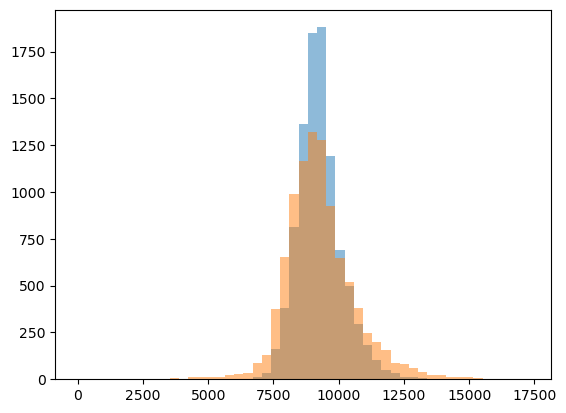

In [ ]:
plt.hist(train["oof"], bins=np.linspace(0, 60 * 60 * 24 // 5, 50), alpha=0.5)
plt.hist(train["target"], bins=np.linspace(0, 60 * 60 * 24 // 5, 50), alpha=0.5)
plt.show()